# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Get the data for notMNIST

In [1]:
from urllib.request import urlretrieve
import tarfile
from os.path import isdir, isfile
from os import remove

def folder_file_name(urlpath):
    """
    Takes a URL and returns the characters after the final '/' as
    the filename. In the filename, everything up until the first 
    period is declared to be the foldername, i.e. the folder-name
    to which a tar file would be unpackaged.
    """
    # We first find the index where the name of the file begins
    indexname = urlpath.rfind("/")
    # Now we get the file name
    filename = urlpath[indexname+1:]
    # We will do the same for the folder name
    folderindex = filename.find(".")
    foldername = filename[:folderindex]
    return filename, foldername

def download_and_unpackage(urlpath):
    """
    Downloads a file given by the url address and unpackages it
    into the same directory. It then removes the compressed file.
    """
    filename, foldername = folder_file_name(urlpath)
    # We only want to download and unpackage if we haven't already done it
    if isdir(foldername) != True:
        urlretrieve(urlpath, filename)
        with tarfile.open(filename, mode='r:gz') as compressed_file:
            compressed_file.extractall()
            compressed_file.close()
        remove(filename)

# Now the data for notMNIST
download_and_unpackage("http://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz")
download_and_unpackage("http://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz")

## Preprocess data

In [2]:
import scipy.ndimage
import os
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

### Find path names of files and prepare one-hot encoder

In [3]:
# We first get all path-names for the training and testing images
training_pathnames = [[folderandfiles[0]+"/"+imname for imname in folderandfiles[2]] 
                          for folderandfiles in os.walk("./notMNIST_large") if folderandfiles[2]!=[]]
testing_pathnames = [[folderandfiles[0]+"/"+imname for imname in folderandfiles[2]] 
                          for folderandfiles in os.walk("./notMNIST_small") if folderandfiles[2]!=[]]
# training_pathnames has the structure:
#[[list of path-names in first folder], [list of paths in second folder], ...]

def get_letter(filepath):
    """
    Returns the letter corresponding to an image found in filepath
    """
    # The letter is given by the name of the folder in which we find the image
    indexname = filepath.rfind("/")
    letter = filepath[indexname-1:indexname]
    return letter

# In each folder all images depict the same letter
all_letters = np.sort([get_letter(pathname[0]) for pathname in training_pathnames])

# We may now make the function that one-hot-encodes letters into arrays
enc = LabelBinarizer()
enc.fit(all_letters)

def one_hot_encode(list_of_letters):
    """
    One hot encode a list of letters. Returns a one-hot encoded vector for each letter.
    """
    return enc.transform(list_of_letters)

# We now flatten the lists of path names
training_pathnames = np.array(sum(training_pathnames, []))
testing_pathnames = np.array(sum(testing_pathnames, []))

# When trainig, we don't want theimages to be ordered. Therefore, we take a 
# random permutation of their order.
np.random.seed(42)
training_pathnames = np.random.permutation(training_pathnames)

### Load images and labels into arrays, save to disk

We first normalize the pixel-values to lie between 0 and 1. We also reshape each image to be a 3-dimensional array: (x_length, y_length, color_channels). 

Finally, we save the arrays to disk.

In [4]:
def load_normalize_image(path):
    """
    Takes the directory path of an image and returns a normalized
    3-dimensional array representing that image.
    """
    # First we load the image
    try:
        imagearray = scipy.ndimage.imread(path)
        # Now we normalize it 
        imagearray = imagearray / 255
        # We reshape it to be 3-dimensional: x-dim, y-dim, num_colors
        imagearray = imagearray.reshape(imagearray.shape + (1,))
        return imagearray
    except:
        # Some images are broken in the database; these will raise errors.
        pass
    
def array_all_images(list_of_path_names):
    """
    Takes a list of directory paths to images and returns a 4-dimensional array
    containing the pixel-data of those images. The shape is:
    (num_images, x_dim, y_dim, num_colors)
    """
    all_images = [load_normalize_image(path) for path in list_of_path_names]
    # Some of these might be None since the function load_normalize_image
    # does not load broken images. We now remove these Nones.
    all_images = np.array(list(filter(None.__ne__, all_images)))
    return all_images

def load_letter(path):
    """
    Takes the directory path of an image and returns a the letter-label of the image.
    """
    # First we see if it is possible to load the image
    try:
        imagearray = scipy.ndimage.imread(path)
        # If this didn't give an error, we may get the letter
        return get_letter(path)
    except:
        # Some images are broken in the database; these will raise errors.
        pass

def array_all_labels(list_of_path_names):
    """
    Takes a list of directory paths to images and returns a 2-dimensional array
    containing the one-hot-encoded labels of those images
    """
    the_letters = [load_letter(path) for path in list_of_path_names]
    the_letters = list(filter(None.__ne__, the_letters))
    all_labels = one_hot_encode(the_letters)
    return all_labels

def batch_list(inputlist, batch_size):
    """
    Returns the inputlist split into batches of maximal length batch_size.
    Each element in the returned list (i.e. each batch) is itself a list.
    """
    list_of_batches = [inputlist[ii: ii+batch_size] for ii in range(0, len(inputlist), batch_size)]
    return list_of_batches

# We store all the data in a training and testing folder
if not os.path.exists("training_data"):
    os.makedirs("training_data")
if not os.path.exists("testing_data"):
    os.makedirs("testing_data")
    
# Make the input data and labels for the testing set
if isfile("./testing_data/testing_images.npy") == False:
    testing_images = array_all_images(testing_pathnames)
    np.save("./testing_data/testing_images.npy", testing_images)
if isfile("./testing_data/testing_labels.npy") == False:
    testing_labels = array_all_labels(testing_pathnames)
    np.save("./testing_data/testing_labels.npy", testing_labels)

# The trainining examples need to be turned into batches
def batch_list(inputlist, batch_size):
    """
    Returns the inputlist split into batches of maxmial length batch_size.
    Each element in the returned list (i.e. each batch) is itself a list.
    """
    list_of_batches = [inputlist[ii: ii+batch_size] for ii in range(0, len(inputlist), batch_size)]
    return list_of_batches

# Here we specify the size of each batch
batch_size = 2**12

# Now we save the batch-data, unless it already exists
training_pathnames_batches = batch_list(training_pathnames, batch_size)
num_saved_batches = sum(["training_images_batch" in filename 
                         for filename in list(os.walk("./training_data"))[0][2]])

# If we have a different number of batches saved comapred to what we want,
# the batches are wrong and need recomputing.
if num_saved_batches != len(training_pathnames_batches):
    # We could delete the old files, but this is dangerous, since a 
    # typo could remove all files on the computer. We simply overwrite the files we have
    for ii, batch in enumerate(tqdm(training_pathnames_batches)):
        training_images_batch = array_all_images(batch)
        np.save("./training_data/training_images_batch" + str(ii) + ".npy", training_images_batch)

        training_labels_batch = array_all_labels(batch)
        np.save("./training_data/training_labels_batch" + str(ii) + ".npy", training_labels_batch)

### Load and display an image

Image shape: (28, 28, 1)


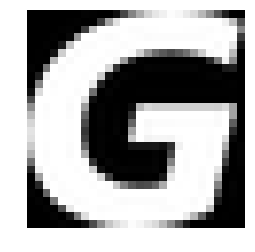

In [5]:
def load_training_data(batch_number, image_numbers=[]):
    """
    Loads the training data from files. It is possible to specify an interval 
    of images to load, or by defauly load th entire batch.
    """
    if image_numbers == []:
        return np.load("./training_data/training_images_batch" + str(batch_number) + ".npy")
    else:
        return np.load("./training_data/training_images_batch" + str(batch_number) + ".npy")[image_numbers]
    
def load_training_labels(batch_number, image_numbers=[]):
    """
    Loads the training data from files. It is possible to specify an interval 
    of images to load, or by defauly load th entire batch.
    """
    if image_numbers == []:
        return np.load("./training_data/training_labels_batch" + str(batch_number) + ".npy")
    else:
        return np.load("./training_data/training_labels_batch" + str(batch_number) + ".npy")[image_numbers]
    
def display_image(imagearray):
    array_to_plot = imagearray.reshape((imagearray.shape[0], imagearray.shape[1]))
    print("Image shape: {}".format(imagearray.shape))
    plt.imshow(array_to_plot, cmap="gray")
    plt.axis("off")
    plt.show()
    
display_image(load_training_data(0)[0])

# TensorFlow Neural Network

This code significantly overlaps with the code from Project 5: Image Classification, in my [GitHub folder](https://github.com/dangall/Udacity-Machine-Learning-Nanodegree/blob/master/P5_image_classification/image_classification.ipynb).

### Set up functions necessary to build the neural network

#### Input

In [6]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], name="x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, [None, n_classes], name="y")


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, name="keep_prob")

#### Convolution and Max Pooling

In [7]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """    
    # Number of input colors
    num_inputcolors = x_tensor.shape.as_list()[3]
    
    # Convolutional filter
    W_conv= tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], num_inputcolors, conv_num_outputs], stddev=0.1))
    b_conv = tf.Variable(tf.constant(0.1, shape=[conv_num_outputs]))
    
    convolution = tf.nn.conv2d(x_tensor, W_conv, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    h_conv = tf.nn.relu(convolution + b_conv)
    
    h_pool = tf.nn.max_pool(h_conv, ksize=[1, pool_ksize[0], pool_ksize[1], 1], 
                            strides=[1, pool_strides[0], pool_strides[1], 1], padding='SAME')
    
    return h_pool 

#### Flatten Layer

In [8]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """    
    flat_dimension = np.prod(x_tensor.shape.as_list()[1:])
    x_flat = tf.reshape(x_tensor, [-1, flat_dimension])

    return x_flat

#### Fully-Connected Layer

In [9]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """    
    input_dimensions = x_tensor.shape.as_list()[1]    
    W = tf.Variable(tf.truncated_normal([input_dimensions, num_outputs], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[num_outputs]))
    
    h_connected = tf.nn.relu(tf.matmul(x_tensor, W) + b)
    
    return h_connected

#### Output Layer

In [10]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    input_dimensions = x_tensor.shape.as_list()[1]    
    W = tf.Variable(tf.truncated_normal([input_dimensions, num_outputs], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[num_outputs]))
    
    h_output = tf.matmul(x_tensor, W) + b
    
    return h_output

### Build Convolutional Neural Network

In [11]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    convlayer_1 = tf.nn.dropout(conv2d_maxpool(x, 20, (4, 4), (1, 1), (2, 2), (2, 2)), keep_prob)
    #convlayer_1b = tf.nn.dropout(conv2d_maxpool(convlayer_1, 10, (4, 4), (1, 1), (2, 2), (1, 1)), keep_prob)
    
    convlayer_2 = tf.nn.dropout(conv2d_maxpool(convlayer_1, 30, (4, 4), (1, 1), (2, 2), (2, 2)), keep_prob)
    #convlayer_2b = conv2d_maxpool(convlayer_2, 20, (1, 1), (1, 1), (1, 1), (1, 1))
    
    convlayer_3 = tf.nn.dropout(conv2d_maxpool(convlayer_2, 60, (4, 4), (1, 1), (2, 2), (2, 2)), keep_prob)
    #convlayer_3b = conv2d_maxpool(convlayer_3, 50, (1, 1), (1, 1), (1, 1), (1, 1))

    # Function Definition from Above:
    #   flatten(x_tensor)
    flattened_tensor = flatten(convlayer_3)
    
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    connlayer_1 = tf.nn.dropout(fully_conn(flattened_tensor, 200), keep_prob)
    
    connlayer_2 = tf.nn.dropout(fully_conn(connlayer_1, 100), keep_prob)
    
    connlayer_3 = tf.nn.dropout(fully_conn(connlayer_2, 30), keep_prob)
    
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    outputlayer = output(connlayer_3, 10)

    return outputlayer

#=============================
#  Build the Neural Network
#=============================

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((28, 28, 1))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
#logits = conv_net(x, keep_prob)
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

### Train the neural network

#### Hyperparameters

In [12]:
epochs = 30
keep_probability = 0.5
learning_rate = 0.0001 # default is 0.001 N.B. it is also possible to make this a placeholder object!
size_of_minibatch = 2**7

#===============================
# Don't need to edit below this
#===============================

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Print cost and accuracy

In [13]:
# The final batch will be our validation set
validation_inputarray = load_training_data(num_saved_batches - 1)
validation_labels = load_training_labels(num_saved_batches - 1)

def get_stats(session, feature_batch, label_batch, cost, accuracy, printout=True):
    """
    Obtain information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    cost_value = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob:1.0})
    accuracy_value = session.run(accuracy, feed_dict={x: validation_inputarray, 
                                                      y: validation_labels, keep_prob:1.0})
    if printout:
        print("\nLoss: {}".format(cost_value))
        print("Accuracy (validation): {}".format(accuracy_value))
    return cost_value, accuracy_value

# Choose which of the training or testing cells below to use

#### Train on a single batch

In order to pick the best hyperparameters, we begin by training on a single batch. This will tell us when to stop the learning and will help in choosing a learning rate.

In [ ]:
batch_i = 0

print('Checking the Training on a Single Batch, i.e. number {}'.format(batch_i))

accuracy_list = []
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for batch_inputarrays, batch_labels in zip(batch_list(load_training_data(batch_i), size_of_minibatch),
                                                   batch_list(load_training_labels(batch_i), size_of_minibatch)):
            sess.run(optimizer, feed_dict={x: batch_inputarrays, y: batch_labels, keep_prob: keep_probability})
        cost_value, accuracy_value = get_stats(sess, batch_inputarrays, batch_labels, cost, accuracy, 
                                               printout=False)
        #print('\nEpoch {:>2}, Batch {}: {} '.format(epoch + 1, batch_i, accuracy_value), end='')
        accuracy_list.append(accuracy_value)
    
    # Save the model
    #saver = tf.train.Saver()
    #save_path = saver.save(sess, "./trained_model", global_step=epoch)
        
plt.plot(accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#### Fully train the model

In [ ]:
print('Training...')

epochs = 30

accuracy_list = []
with tf.Session() as sess:
    # It is very important the saver is defined INSIDE the block "with tf.Session() as sess"
    # otherwise it will be very difficult to load the graph (unless we name all the variables etc)
    saver = tf.train.Saver()
    
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        for batch_i in range(num_saved_batches - 1):
            for batch_inputarrays, batch_labels in zip(batch_list(load_training_data(batch_i), 
                                                                  size_of_minibatch),
                                                       batch_list(load_training_labels(batch_i), 
                                                                  size_of_minibatch)
                                                      ):
                sess.run(optimizer, feed_dict={x: batch_inputarrays, y: batch_labels, keep_prob: keep_probability})
            cost_value, accuracy_value = get_stats(sess, batch_inputarrays, batch_labels, cost, accuracy, 
                                                   printout=False)
            print('Epoch {:>2}, Batch {}: {}'.format(epoch + 1, batch_i, accuracy_value))
        
        accuracy_list.append(accuracy_value)
        
        if epoch % 10 == 0:
            # Save the intermediate model
            save_path = saver.save(sess, "./trained_model", global_step=epoch)
    
    # Save the final model
    save_path = saver.save(sess, "./trained_model", global_step=epoch)
        
plt.plot(accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#### Fine-tune a trained model

In [ ]:
# Decrease the learning rate for the final part!

epochs = 30
load_model = "./trained_model-29"

# read off the epoch from the number in load_model
next_epoch = int(load_model[load_model.rfind("-")+1:]) + 1

new_accuracy_list = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    
    saver.restore(sess, load_model)
    print(sess.run(accuracy, feed_dict={x: validation_inputarray,
                                        y: validation_labels, keep_prob:1.0}))
    
    # Training cycle
    for epoch in range(next_epoch, next_epoch + epochs):
        for batch_i in range(num_saved_batches - 1):
            for batch_inputarrays, batch_labels in zip(batch_list(load_training_data(batch_i), 
                                                                  size_of_minibatch),
                                                       batch_list(load_training_labels(batch_i), 
                                                                  size_of_minibatch)
                                                      ):
                sess.run(optimizer, feed_dict={x: batch_inputarrays, y: batch_labels, 
                                                  keep_prob: keep_probability})
            cost_value, accuracy_value = get_stats(sess, batch_inputarrays, batch_labels, cost, accuracy,
                                                   printout=False)
            print('Epoch {:>2}, Batch {}: {}'.format(epoch + 1, batch_i, accuracy_value))
        
        new_accuracy_list.append(accuracy_value)
        
        if epoch % 10 == 0:
            # Save the intermediate model
            save_path = saver.save(sess, "./trained_model", global_step=epoch)
            
    # Save the final model
    save_path = saver.save(sess, "./trained_model", global_step=epoch)

In [ ]:
plt.plot(new_accuracy_list)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

#### Test model

In [14]:
load_model = "./trained_model-59"
testing_inputarray = np.load("./testing_data/testing_images.npy")
testing_labels = np.load("./testing_data/testing_labels.npy")

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    
    saver.restore(sess, load_model)
    print("The model's test-set accuracty is {}%".format(np.round(sess.run(accuracy, 
                                                                            feed_dict={x: testing_inputarray,
                                        y: testing_labels, keep_prob:1.0})*100, decimals=2)))

The model's test-set accuracty is 96.64%


# Optional future work

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.